In [1]:
from go2_env import Go2Env
import jax
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List
import mediapy as media
import matplotlib.pyplot as plt
import mujoco
from mujoco import mjx
import jax.numpy as jp
import os
import functools
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from orbax import checkpoint as ocp
from flax.training import orbax_utils
from etils import epath
from brax.io import  model as brax_model
from datetime import datetime  
from matplotlib.backends.backend_pdf import PdfPages 





# Reference: mjx tutorial on mujoco github
os.environ["MUJOCO_GL"] = "egl"
xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Use the 'tab20' colormap
plt.rc('axes', prop_cycle=plt.cycler('color', plt.cm.tab20.colors))



In [ ]:
go2_env =  Go2Env()
prng = jax.random.PRNGKey(0)
state =  go2_env.reset(prng) 
tic = time.time()
step_jit = jax.jit(go2_env.step)
toc = time.time()
print("elapsed time jit", toc - tic)
num_steps = 100
ctrl = jp.zeros(12)
states = []
tic = time.time()
for i in range(num_steps): 
    state = step_jit(state, ctrl)
    states.append(state.pipeline_state)
toc = time.time()
print(f"elapsed time {num_steps} steps", toc - tic)

tic = time.time()
frames = go2_env.render(states, camera="track")
toc = time.time()
print("elapsed time render", toc - tic)
print("done!")
media.show_video(frames, fps=30)

In [ ]:
# lets do a normal simluation in mujoco.
frames = []
mj_model =  mujoco.MjModel.from_xml_path('../Go2Py/assets/mujoco/go2.xml')
mj_data = mujoco.MjData(mj_model)

mj_data.qpos[:] = mj_model.keyframe('home').qpos
mj_data.qvel = np.zeros(mj_model.nv)
mujoco.mj_forward(mj_model, mj_data)
print(mj_data.body('base').xpos)
num_steps = 1000
ctrl = np.zeros(mj_model.nu)
kp = 35
kd = .5
renderer = mujoco.Renderer(mj_model)
save_one_every = 30
for i in range(num_steps):
    q = mj_data.qpos[7:]
    dq = mj_data.qvel[6:]
    q_des = mj_model.keyframe('home').qpos[7:] + ctrl
    tau = kp * ( q_des - q) - kd * dq
    mj_data.ctrl[:] = tau
    mujoco.mj_step(mj_model, mj_data)
    print("q", q)
    if i % save_one_every == 0:
        renderer.update_scene(mj_data,camera="track")
        pixels = renderer.render()
        frames.append(pixels)
renderer.close()
media.show_video(frames, fps=1)


torso idx
1
torso idx
1
torso idx
1


/usr/local/lib/python3.10/dist-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


step: 0  reward: 28.674
[Evaluation] Saving plot to /tmp/quadrupred_joystick/plots/plot_0.png
step: 1081344  reward: 27.253
[Evaluation] Saving plot to /tmp/quadrupred_joystick/plots/plot_1081344.png
[Checkpoint] Saved at step 1081344 to /tmp/quadrupred_joystick/ckpts/1081344
saving params to 
render
elapsed time 0.6176280975341797
done!
[Video] Saved video to /tmp/quadrupred_joystick/walk_1081344.mp4
[Plot] Added all functions plot to PDF: /tmp/quadrupred_joystick/plots/reward_plots_step_1081344.pdf
[Plot] Saved all reward plots to PDF: /tmp/quadrupred_joystick/plots/reward_plots_step_1081344.pdf
[Evaluation] Reward plotting completed.
step: 2162688  reward: 26.837
[Evaluation] Saving plot to /tmp/quadrupred_joystick/plots/plot_2162688.png
[Checkpoint] Saved at step 2162688 to /tmp/quadrupred_joystick/ckpts/2162688
saving params to 
render
elapsed time 0.4077296257019043
done!
[Video] Saved video to /tmp/quadrupred_joystick/walk_2162688.mp4
[Plot] Added all functions plot to PDF: /tmp

KeyboardInterrupt: 

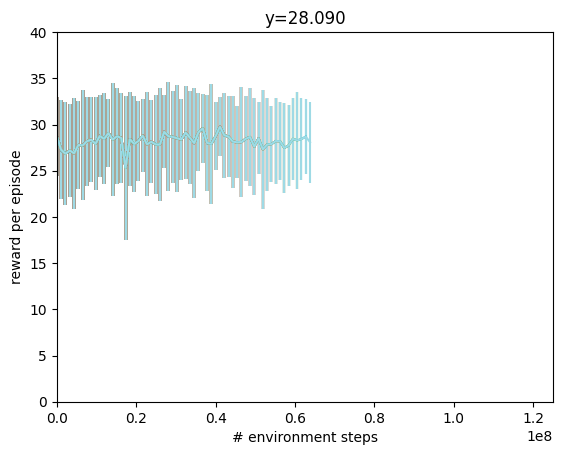

In [2]:
# lets start the training loop
def domain_randomize(sys, rng):
    """Randomizes the mjx.Model."""

    @jax.vmap
    def rand(rng):
        _, key = jax.random.split(rng, 2)
        # friction
        friction = jax.random.uniform(key, (1,), minval=0.5, maxval=1.3)
        friction = sys.geom_friction.at[:, 0].set(friction)
        # todo: randomize something else!
        return friction

    friction = rand(rng)

    in_axes = jax.tree_util.tree_map(lambda x: None, sys)
    in_axes = in_axes.tree_replace({"geom_friction": 0})

    sys = sys.tree_replace(
        {
            "geom_friction": friction,
        }
    )

    return sys, in_axes


# NOTE: parameters that are not inside the mujoco model are randomized by setting
# a flag to the environment.


env_name = "go2"
Fs = .5
mu_v = .3
env = Go2Env(randomize_custom_params=True, Fs=Fs, mu_v=mu_v)
eval_env = Go2Env(randomize_custom_params=True, Fs=Fs, mu_v=mu_v)
eval_env_local = Go2Env(randomize_custom_params=True, Fs=Fs, mu_v=mu_v)
reset = eval_env_local.reset
jit_step = jax.jit(eval_env_local.step)
render = eval_env_local.render
dt = eval_env.dt

plot_path = epath.Path("/tmp/quadrupred_joystick/plots")
ckpt_path = epath.Path("/tmp/quadrupred_joystick/ckpts")
video_path = epath.Path("/tmp/quadrupred_joystick/")
ckpt_path.mkdir(parents=True, exist_ok=True)
video_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)


make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks, policy_hidden_layer_sizes=(128, 128, 128, 128)
)


def policy_params_fn(current_step, make_policy, params):
    """
    Callback function to save policy checkpoints and generate evaluation videos.

    Args:
        current_step (int): The current training step.
        make_policy (Callable): Function to create the policy network.
        params (PyTree): The current parameters of the policy network.
    """
    # Save the current policy parameters as a checkpoint
    orbax_checkpointer = ocp.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(params)
    path = ckpt_path / f"{current_step}"
    orbax_checkpointer.save(path, params, force=True, save_args=save_args)
    print(f"[Checkpoint] Saved at step {current_step} to {path}")

    print("saving params to ")
    model_path = f"/tmp/mjx_brax_quadruped_policy_{current_step}"
    print(model_path)
    brax_model.save_params(model_path, params)

    # Create an inference function from the current parameters

    # _params = _unpmap(
    #       (training_state.normalizer_params, training_state.params.policy))

    inference_fn = make_policy((params[0], params[1].policy))
    jit_inference_fn = jax.jit(inference_fn)  # is this necessary?

    # @markdown Commands **only used for Barkour Env**:
    x_vel = 1.0  # @param {type: "number"}
    y_vel = 0.0  # @param {type: "number"}
    ang_vel = -0.5  # @param {type: "number"}

    the_command = jp.array([x_vel, y_vel, ang_vel])

    # initialize the state
    rng = jax.random.PRNGKey(0)
    state = reset(rng)
    state.info["command"] = the_command
    rollout = [state.pipeline_state]

    # grab a trajectory
    n_steps = 500
    render_every = 2

    # -------------------- 5. Initialize Reward Containers --------------------
    total_rewards = []  # To store total reward per step
    reward_components = {
        k: [] for k in state.info["rewards"].keys()
    }  # To store individual reward components

    # -------------------- 6. Perform Rollout --------------------

    # print("rollout")
    for i in range(n_steps):
        # print("i", i)
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        state = jit_step(state, ctrl)
        rollout.append(state.pipeline_state)

        # Collect rewards
        total_rewards.append(state.reward)  # Total reward for this step
        for k, v in state.info["rewards"].items():
            reward_components[k].append(v)

        if state.done:
            print(f"[Evaluation] Episode terminated at step {i}")
            break

    # Render the rollout frames
    print("render")
    tic = time.time()
    frames = render(rollout[::render_every], camera="track")
    toc = time.time()
    print("elapsed time", toc - tic)
    print("done!")

    # Define the video filename
    video_filename = video_path / f"walk_{current_step}.mp4"

    # Save the video using MediaPy
    media.write_video(
        video_filename.as_posix(), frames, fps=int(1.0 / dt / render_every)
    )
    print(f"[Video] Saved video to {video_filename}")



    # Convert rewards to NumPy arrays for plotting
    total_rewards_np = np.array(total_rewards)
    reward_components_np = {k: np.array(v) for k, v in reward_components.items()}
    
    # Define the PDF filename with current_step
    pdf_filename = plot_path / f"reward_plots_step_{current_step}.pdf"
    
    # Create a PdfPages object to save multiple plots into a single PDF
    with PdfPages(pdf_filename) as pdf:
        # -------------------- First Page: All Functions --------------------
        plt.figure(figsize=(12, 6))
        plt.plot(total_rewards_np, label="Total Reward", color="blue")
        for k, v in reward_components_np.items():
            plt.plot(v, label=k)
        plt.xlabel("Step")
        plt.ylabel("Reward")
        plt.title(f"Total and Reward Components Over Time (Checkpoint {current_step})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        pdf.savefig()  # Save the current figure into the PDF
        plt.close()
        print(f"[Plot] Added all functions plot to PDF: {pdf_filename}")
        
        # -------------------- Subsequent Pages: Individual Costs --------------------
        for k, v in reward_components_np.items():
            plt.figure(figsize=(12, 6))
            plt.plot(v, label=k, color="green")
            plt.xlabel("Step")
            plt.ylabel(f"Reward Component: {k}")
            plt.title(f"Reward Component '{k}' Over Time (Checkpoint {current_step})")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            pdf.savefig()  # Save each individual plot into the PDF
            plt.close()
            #print(f"[Plot] Added individual cost '{k}' to PDF: {pdf_filename}")




        # -------------------- Additional Page: Sum of All Terms as Bar Plot --------------------
        # Calculate the sum of each component over the horizon
        component_sums = {k: np.sum(v) for k, v in reward_components_np.items()}
        
        # Create bar plot
        plt.figure(figsize=(12, 6))
        plt.bar(component_sums.keys(), component_sums.values(), color="orange")
        plt.xlabel("Reward Component")
        plt.ylabel("Total Sum Over Horizon")
        plt.title(f"Total Sum of Reward Components Over Horizon (Checkpoint {current_step})")
        plt.grid(axis="y")
        plt.tight_layout()
        pdf.savefig()  # Save the bar plot into the PDF
        plt.close()

    
    print(f"[Plot] Saved all reward plots to PDF: {pdf_filename}")
    print("[Evaluation] Reward plotting completed.")


    # # -------------------- 8. Plot and Save Rewards --------------------
    # print("[Evaluation] Plotting rewards...")

    # # Convert rewards to NumPy arrays for plotting
    # total_rewards_np = np.array(total_rewards)
    # reward_components_np = {k: np.array(v) for k, v in reward_components.items()}

    # # Define the plot filename with current_step
    # plot_filename_total = plot_path / f"total_reward_step_{current_step}.pdf"
    # plot_filename_components = plot_path / f"reward_components_step_{current_step}.pdf"

    # # Plot Total Reward Over Time
    # plt.figure(figsize=(12, 6))
    # plt.plot(total_rewards_np, label="Total Reward", color="blue")
    # plt.xlabel("Step")
    # plt.ylabel("Total Reward")
    # plt.title(f"Total Reward Over Time (Checkpoint {current_step})")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig(plot_filename_total)
    # plt.close()
    # print(f"[Plot] Saved total reward plot to {plot_filename_total}")

    # # Plot Individual Reward Components Over Time
    # plt.figure(figsize=(14, 8))
    # for k, v in reward_components_np.items():
    #     plt.plot(v, label=k)
    # plt.xlabel("Step")
    # plt.ylabel("Reward Component Value")
    # plt.title(f"Individual Reward Components Over Time (Checkpoint {current_step})")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig(plot_filename_components)
    # plt.close()
    # print(f"[Plot] Saved reward components plot to {plot_filename_components}")

    # print("[Evaluation] Reward plotting completed.")


def progress(num_steps, metrics):
    print(f'step: {num_steps}  reward: {metrics["eval/episode_reward"]:.3f}')
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([0, train_fn.keywords["num_timesteps"] * 1.25])
    plt.ylim([min_y, max_y])

    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")

    plt.errorbar(x_data, y_data, yerr=ydataerr)
    fout = f"/tmp/quadrupred_joystick/plots/plot_{num_steps}.png"
    print(f"[Evaluation] Saving plot to {fout}")
    plt.savefig(fout)

# ckpt = "/root/home/Go2py/examples/qpolicy_no_friction"
#"/tmp/quadrupred_joystick/ckpts/201719808"
#ckpt = "/tmp/quadrupred_joystick/ckpts/201719808"
#ckpt = "/tmp/quadrupred_joystick/ckpts/82182144" # this is with randomized kp from 20 to 25
ckpt = "/tmp/quadrupred_joystick/ckpts/5406720" # this has been trained with friction from 0. to 1.

# i run:
# root@mango:/home/Go2py# cp -r /tmp/quadrupred_joystick/ckpts/82182144 examples/qpolicy_kp
# root@mango:/home/Go2py# cp -r /tmp/quadrupred_joystick/ckpts/5406720 examples/qpolicy_fs
# notes: 
# curriculum: first kp from 20 to 25
# then Fs from 0 to 1 (short) <-- this step might not even be necessary!
# then Fs from 0 to 3 (long)

# final one is: /tmp/quadrupred_joystick/ckpts/63799296

# cp /tmp/mjx_brax_quadruped_policy_63799296 examples/qpolicy_fs_03_params

train_fn = functools.partial(
    ppo.train,
    # num_timesteps=100_000_000,
    num_timesteps=100_000_000,
    num_evals=100,
    reward_scaling=1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=24,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.99,
    learning_rate=3.0e-4,
    entropy_cost=1e-2,
    num_envs=int(8192 / 2),
    batch_size=128,
    network_factory=make_networks_factory,
    randomization_fn=domain_randomize,
    policy_params_fn=policy_params_fn,
    restore_checkpoint_path= ckpt,
    seed=0,
)


# train_fn = functools.partial(
#     ppo.train,
#     num_timesteps=200_000_000,
#     # num_timesteps=100_000,
#     num_evals=10,
#     reward_scaling=1,
#     episode_length=1000/2,
#     normalize_observations=True,
#     action_repeat=1,
#     unroll_length=24,
#     num_minibatches=32,
#     num_updates_per_batch=4,
#     discounting=0.99,
#     learning_rate=3.0e-4,
#     entropy_cost=1e-2,
#     num_envs=int(8192 / 2),
#     batch_size=128,
#     network_factory=make_networks_factory,
#     randomization_fn=domain_randomize,
#     policy_params_fn=policy_params_fn,
#     # restore_checkpoint_path= '/tmp/quadrupred_joystick/ckpts/88883200',
#     seed=0,
# )

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_y, min_y = 40, 0


make_inference_fn, params, _ = train_fn(
    environment=env, progress_fn=progress, eval_env=eval_env
)
print("done!")